# Classical geostatistics (geosclassic wrapper) - indicator variables (2D)

Estimation and simulation for a categorical variable, based on simple and ordinary kriging.
- estimation: estimate probabilities for each category
    - hard data only
    - search ellipsoid or unique neighborhood
- simulation: sequential indicator simulation (SIS) based on simple and ordinary kriging
    - hard data
    - search ellipsoid only

The covariance model can be
- stationary, *i.e.* any parameter (weight (or sill), ranges, orientation angle, etc.) is constant
- non-stationary, *i.e.* with some parameter (weight (or sill), ranges, orientation angle, etc.) depending on the location in the grid. *Note:* with a non-stationary covariance model
    - some functionalities such as getting the sill, range, or plotting the model are not available
    - a unique neighborhood can not be used for estimation

Simple kriging allows to specify the probability of each category, stationary (global) or non-stationary (local). By default the probabilities are set to the proportion of each category in the hard data values (stationary) or a uniform distribution if no hard data is present.

For ordinary kriging: the specified probabilities are used when estimation or simulation is done in a grid cell without any neighbor.

**Remark:** examples in 2D are proposed here.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.5


### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Define the category values
A list of category values (facies) must be defined. Let `ncategory` be the length of this list, *i.e.* the number of categories.
- if `ncategory == 1`: the unique category value given must not be equal to 0; this is used for a binary case with values ("unique category value", 0), where 0 indicates the absence of the considered medium; conditioning data values should be "unique category value" or 0
- if `ncategory >= 2`: this is used for a multi-category case with given values (distinct); conditioning data values should be in the list of given values

In [3]:
category_values = [1., 2., 3.]
ncategory = len(category_values)

Set color for each category, and color maps for proportions (for further plots).

In [4]:
categCol = ['lightblue', 'orange', 'darkgreen']
cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]

## Define the covariance model(s)
A covariance model is required for each category. If only one is defined, it is used for every category (it is ''recycled'').

Here in 2D, we define covariance model(s) in 2D: class `covModel2D`.

(See jupyter notebooks `ex_geosclassic_[123]d*.ipynb` for details.)

In [5]:
cov_model = gn.covModel.CovModel2D(elem=[
    ('exponential', {'w':9., 'r':[150, 40]}), # elementary contribution
    ], alpha=-30, name='model-2D example')

## Launching simulation and estimation
The following functions are used:
- `geone.geosclassicinterface.simulateIndicator<n>D` for simulation \<n\>D (sequential indicator simulation, SIS),
- `geone.geosclassicinterface.estimateIndicator<n>D` for estimation \<n\>D (estimate probabilities),

where `n` is the space dimension (`1`, `2`, or `3`).

These functions launch a C program running in parallel (based on *OpenMP*) for the simulation / estimation **in a grid**, after that raw conditioning data has been aggregated in the grid cells (see "Data aggregation in grid" below). The number of threads used can be specified by the optional parameter (keyword argument) `nthreads`. Specifying for this parameter a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

The first argument is the list of category of length `ncategory`, and the (list of) covariance model(s) is given as second argument.

The parameters (keyword arguments) `searchRadiusRelative`, `searchNeighborhoodSortMode`, and
`use_unique_neighborhood` are lists of length `ncategory`. As for the covariance model, if only one value (not a list is given), it is recycled. Each entry in the list is related to the corresponding category in the list of category values given in first argument. These parameters have a similar role as in the functions for simulation and estimation for a continuous values, *i.e.* `geone.geosclassicinterface.simulate<n>D` and `geone.geosclassicinterface.estimate<n>D` (see jupyter notebooks `ex_geosclassic_[123]d*.ipynb` for details.)

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1` (default): version and warning(s) encountered, `verbose=2`: version, progress, and warning(s) encountered. Note that due to *buffering*, progress might not be displayed immediately and then could be useless.

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only errors (if any), `verbose=2` (default): version and warning(s) encountered, `verbose=3`: version, progress, and warning(s) encountered. Note that due to *buffering*, progress might not be displayed immediately and then could be useless.

### Data aggregation in grid
As the simulation / estimation is done in a grid, the conditioning data are first aggregated in the grid cells, i.e. data points falling in the same grid cell are aggregated in one unique value at the cell centre, by taking the most frequent category.

### Launching multiple processes for simulation 
The function `geone.geosclassicinterface.simulateIndicator<n>D_mp` launches multiple processes. 

Specifying the number of processes, `nproc`, and the number of threads per process, `nthreads_per_proc`, this function will run `nproc` parallel processes (parallel calls of function `geone.geosclassicinterface.simulateIndicator<n>D`), each one using `nthreads_per_proc` threads. 

In terms of resources, this implies the use of `nproc` $\cdot$ `nthreads_per_proc` cpu(s). 

If `nproc=None` (default), `nproc` is set to $n_{cpu}-1$ (but at least $1$), where $n_{cpu}$ is the total number of cpu(s) of the system (retrieved by `multiprocessing.cpu_count()`). If `nthreads_per_proc=None`, `nthreads_per_proc` is set to the maximal integer (but at least 1) such that `nproc` $\cdot$ `nthreads_per_proc` $\leqslant n_{cpu}-1$.

Note that (if not `None`), `nproc` and `nthreads_per_proc` must be positive integers. These parameters must be set cautiously, because the product `nproc` $\cdot$ `nthreads_per_proc` can exceed $n_{cpu}$, the total number of cpu(s) of the system. Note also that, `nproc` will be reduced to the number of realizations (but at least 1) if `nproc` was set larger.

It is recommended to specify the number of parallel processes (`nproc`) and the number of threads per process (`nthreads_per_proc`).

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only errors and notes (if any), `verbose=2` (default): version and warning(s) encountered.

### Examples

Define the simulation grid.

In [6]:
nx, ny = 220, 230  # number of cells
sx, sy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (sx, sy)
origin = (ox, oy)

### Unconditional simulations

#### Using function `geone.geosclassicinterface.simulateIndicator<n>D`

In [7]:
nreal = 100
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal,
    nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 14 sec


#### Using multiple processes, function `geone.geosclassicinterface.simulateIndicator<n>D_mp`

In [8]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using multiple processes
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output2 = gn.geosclassicinterface.simulateIndicator2D_mp(
    category_values, cov_model, dimension, spacing, origin, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal,
    nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(
    np.all(geosclassic_output2['image'].val== geosclassic_output['image'].val))) # should be True

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 17 sec
Identical result: True


### Retrieve the results (and display)
The function `geone.geosclassicinterface.simulateIndicator<n>D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The realizations are stored in `geosclassic_output['image']`, an *image* (class `geone.img.Img`) with as many variables as realizations (the i-th variable being the i-th realization).

The total number of warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distinct warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [9]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [10]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

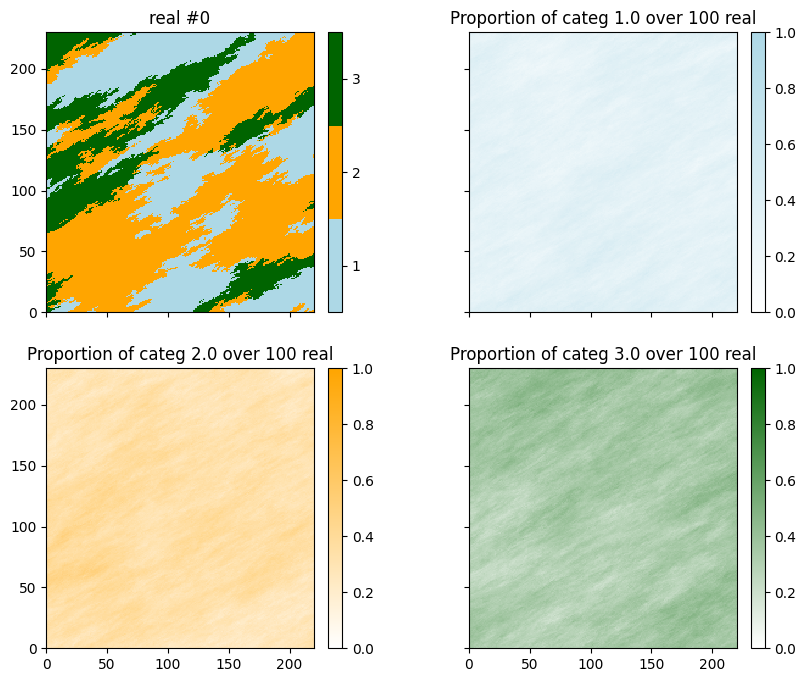

In [11]:
# Plot
plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    gn.imgplot.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Proportion of categ {} over {} real'.format(category_values[i], nreal))

plt.show()

### Conditional simulations (hard data)
#### Function `geone.geosclassicinterface.simulateIndicator<n>D[_mp]`

Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [12]:
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ 1., 2., 1., 3.] # values

Launch the simulations and plot.

In [13]:
nreal = 100
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal,
    nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 15 sec


In [14]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using multiple processes
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output2 = gn.geosclassicinterface.simulateIndicator2D_mp(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal,
    nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(
    np.all(geosclassic_output2['image'].val== geosclassic_output['image'].val))) # should be True

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 17 sec
Identical result: True


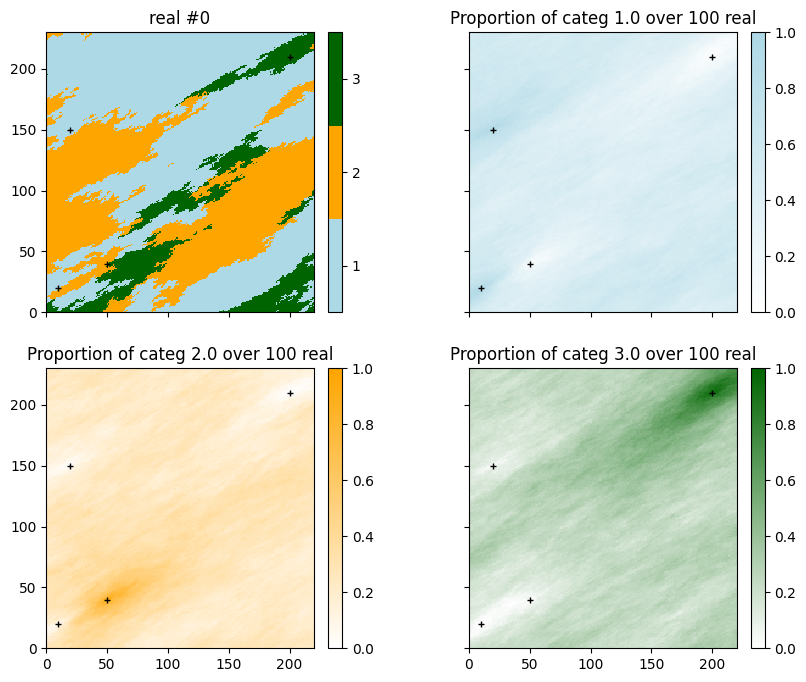

In [15]:
# Plot
plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    gn.imgplot.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Proportion of categ {} over {} real'.format(category_values[i], nreal))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

### Estimation: estimate probabilities (by kriging)
#### Function `geone.geosclassicinterface.estimateIndicator<n>D`

In [16]:
# Increase searchRadiusRelative to avoid "discontinuities"
# t1 = time.time() # start time
# geosclassic_output = gn.geosclassicinterface.estimateIndicator2D(
#     category_values, cov_model, dimension, spacing, origin, 
#     x=x, v=v, method='simple_kriging',
#     searchRadiusRelative=2.0,
#     nthreads=8)
# t2 = time.time() # end time
# print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Or use a unique neighborhood
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging',
    use_unique_neighborhood=True,
    nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 0.036 sec


### Retrieve the results (and display)
The function `geone.geosclassicinterface.estimateIndicator<n>D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The estimate probabilities are stored in `geosclassic_output['image']`, an *image* (class `geone.img.Img`) with `ncategory` variables: the i-th variable is the estimated probabilities for the i-th category.

As for the function `geone.geosclassicinterface.simulateIndicator<n>D`, the warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distinct warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [17]:
# Retrieve the results of estimation
estim = geosclassic_output['image']

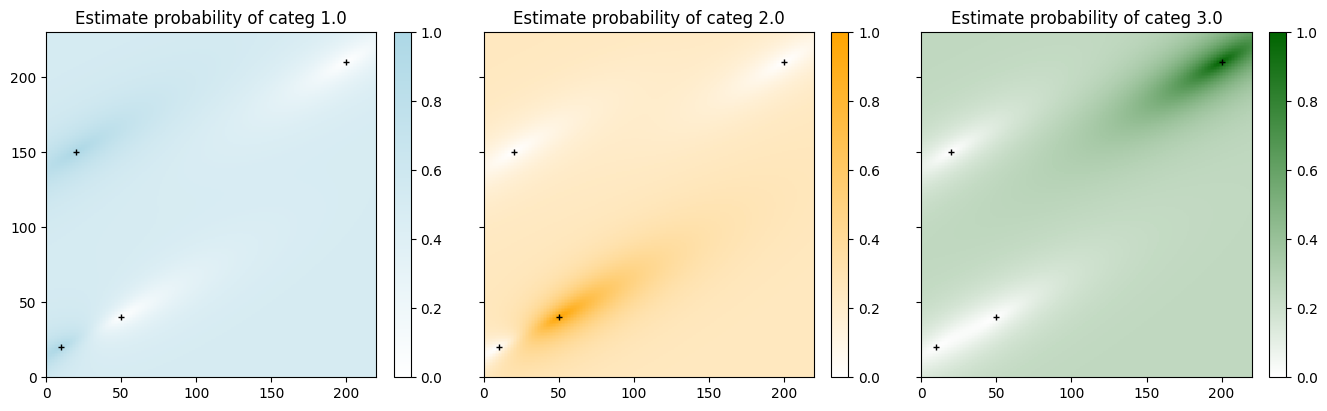

In [18]:
plt.subplots(1, 3, figsize=(16,12), sharey=True)

for i in range(ncategory):
    plt.subplot(1,3,1+i)
    gn.imgplot.drawImage2D(estim, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Estimate probability of categ {}'.format(category_values[i]))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

### Simple and ordinary kriging

In [19]:
# simulation based on simple kriging
np.random.seed(444)
geosclassic_output = gn.geosclassicinterface.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', nreal=1, nthreads=8)
simul_simple_krig = geosclassic_output['image']

# estimation based on simple kriging
np.random.seed(444)
geosclassic_output = gn.geosclassicinterface.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', use_unique_neighborhood=True, nthreads=8)
estim_simple_krig = geosclassic_output['image']

# simulation based on ordinary kriging
geosclassic_output = gn.geosclassicinterface.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='ordinary_kriging', nreal=1, nthreads=8)
simul_ordinary_krig = geosclassic_output['image']

# estimation based on ordinary kriging
geosclassic_output = gn.geosclassicinterface.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='ordinary_kriging', use_unique_neighborhood=True, nthreads=8)
estim_ordinary_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete


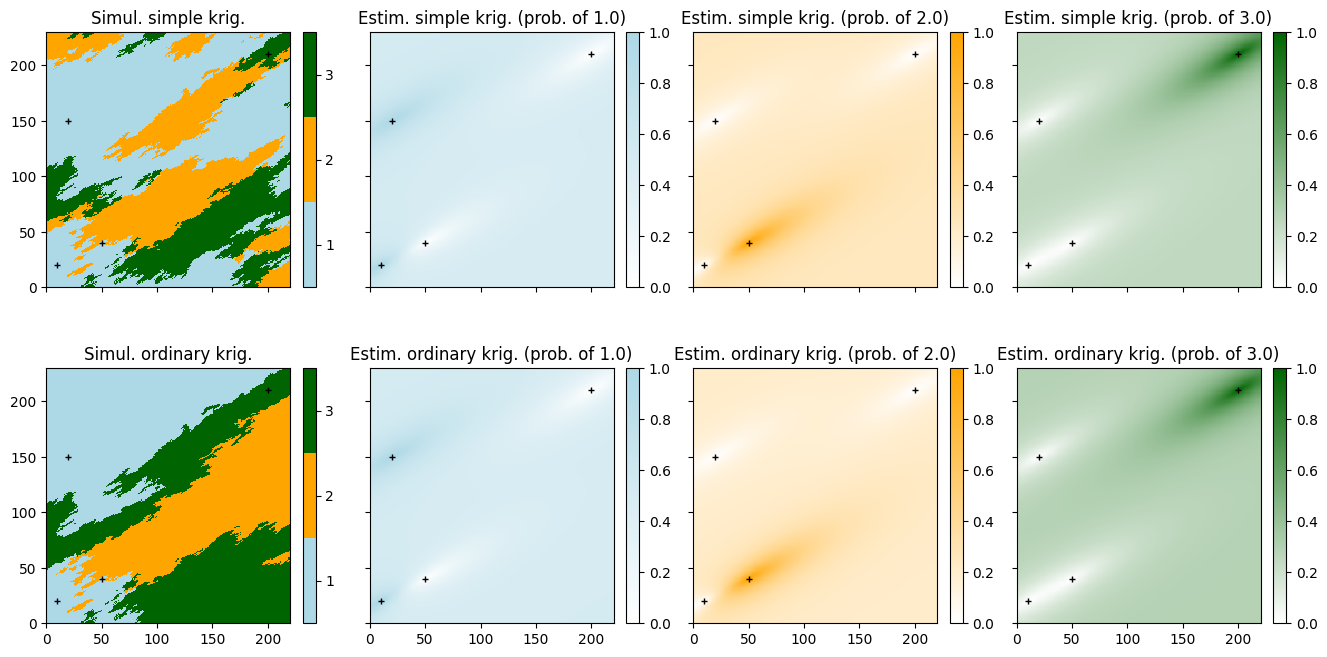

In [20]:
# plot
plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True)

plt.subplot(2, 4, 1)
gn.imgplot.drawImage2D(simul_simple_krig, iv=0, categ=True, categCol=categCol)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Simul. simple krig.')

for i in range(ncategory):
    plt.subplot(2,4,2+i)
    gn.imgplot.drawImage2D(estim_simple_krig, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])        
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('Estim. simple krig. (prob. of {})'.format(category_values[i]))

plt.subplot(2, 4, 5)
gn.imgplot.drawImage2D(simul_ordinary_krig, iv=0, categ=True, categCol=categCol)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Simul. ordinary krig.')

for i in range(ncategory):
    plt.subplot(2,4,6+i)
    gn.imgplot.drawImage2D(estim_ordinary_krig, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])        
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('Estim. ordinary krig. (prob. of {})'.format(category_values[i]))

plt.show()

### Simulations with prescribed probabilities
Probabilities for the categories can be specified if simple kriging is used, they can be stationary (constant) or non-stationary. By default, the proportions of the categories in the conditioning data are used (or zero if no conditioning data) (constant).

With `ncategory>1`, the sum of probabilities (at each pixel if non-stationary) must sum to 1. If `ncategory==1`, only one value (per pixel if non-stationary) is given which must be between 0 and 1. 

### Simulations with constant probabilities

In [21]:
probability = [.1, .2, .7] # should sum to 1
# Simulation
nreal = 1
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, probability=probability, nreal=nreal,
    nthreads=8)
simul = geosclassic_output['image']

# Estimation
geosclassic_output = gn.geosclassicinterface.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, probability=probability, use_unique_neighborhood=True,
    nthreads=8)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete


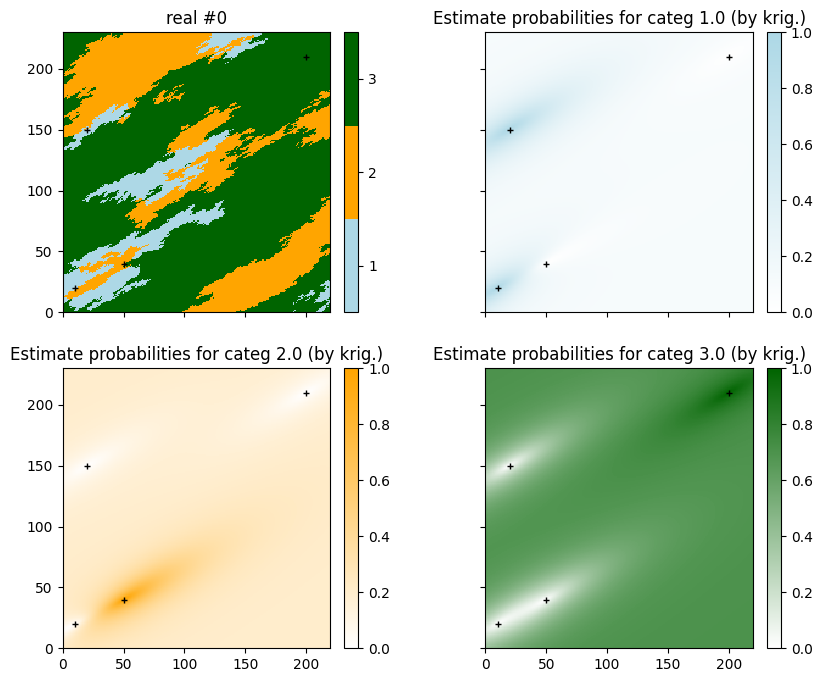

In [22]:
# Plot
plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    gn.imgplot.drawImage2D(estim, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Estimate probabilities for categ {} (by krig.)'.format(category_values[i]))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

### Simulations with non-stationary probabilities
Set varying probabilities over the simulation domain.

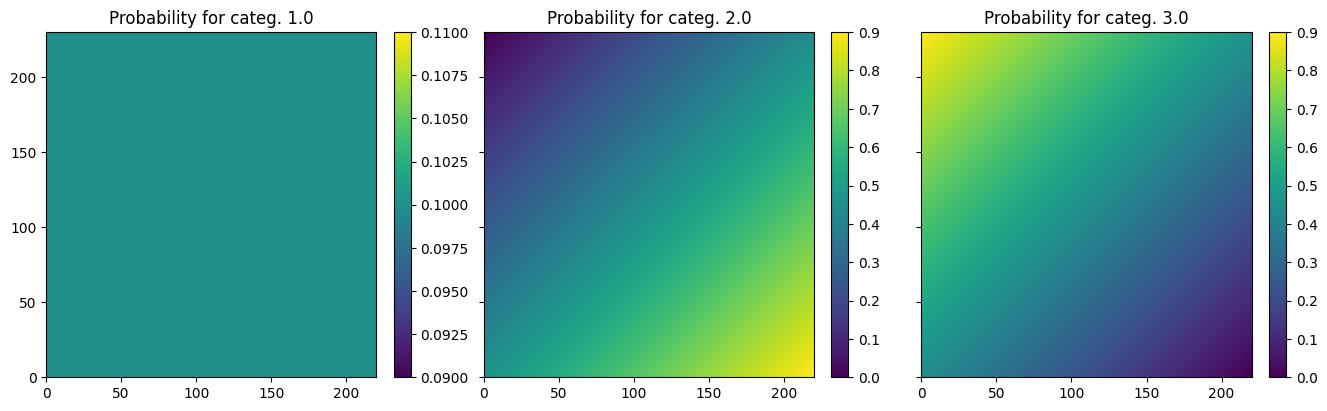

In [23]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()[0]
yy = im.yy()[0]

# Equivalent:
## xg, yg: coordinates of the centers of grid cell
#xg = ox + 0.5*sx + sx*np.arange(nx)
#yg = oy + 0.5*sy + sy*np.arange(ny)
#xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Define probability maps for each category
c = 0.9
p1 = xx - yy     
p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))
p2 = c - p1
p0 = (1. - c) * np.ones_like(p1) # 1.0 - p1 - p2 # constant map (0.1)

probability = np.array((p0, p1, p2))

# Set variable p0, p1, p2 in image im
im.append_var(probability, varname=['p0', 'p1', 'p2'])

# Display 
plt.subplots(1, 3, figsize=(16,12), sharey=True)

for i in range(ncategory):
    plt.subplot(1, 3, 1+i)
    gn.imgplot.drawImage2D(im, iv=i, title = 'Probability for categ. {}'.format(category_values[i]))

plt.show()

In [24]:
nreal = 100
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator2D_mp(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging',
    probability=probability,
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal,
    nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 17 sec


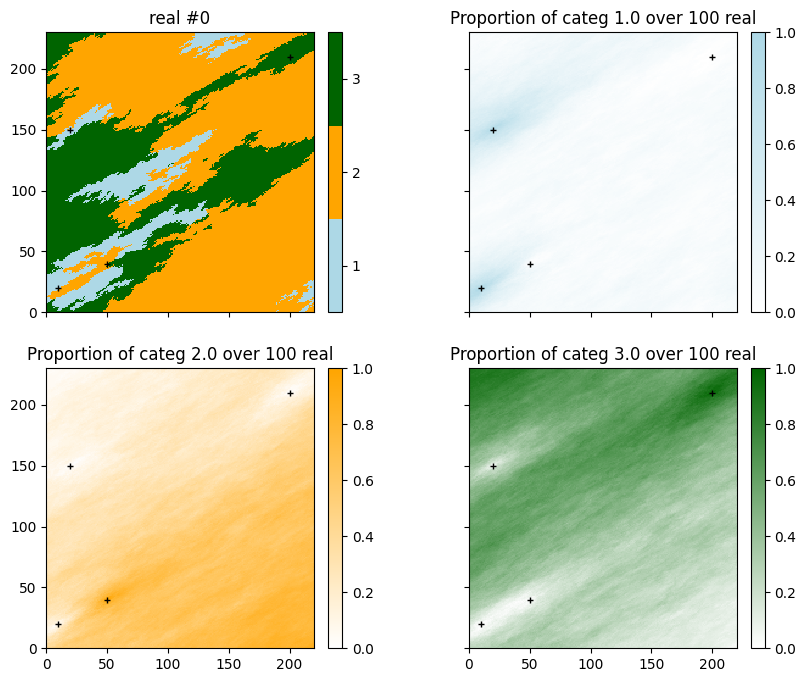

In [25]:
# Plot
plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    gn.imgplot.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Proportion of categ {} over {} real'.format(category_values[i], nreal))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

## Example with non-stationary covariance model
As for simulation and estimation for a continuous variable, non-stationary covariance model can be defined. For details, see jupyter notebooks `ex_geosclassic_[123]d_non_stat_cov.ipynb`.

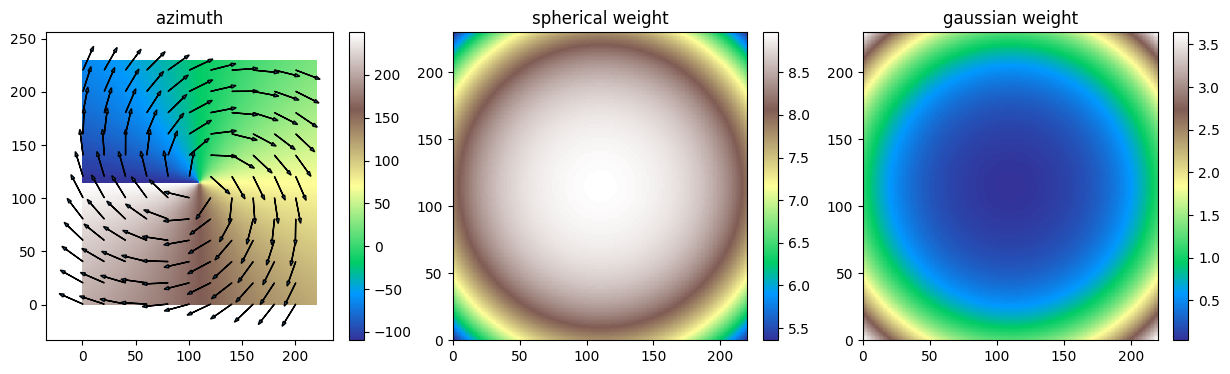

In [26]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()[0]
yy = im.yy()[0]

# Equivalent:
## xg, yg: coordinates of the centers of grid cell
#xg = ox + 0.5*sx + sx*np.arange(nx)
#yg = oy + 0.5*sy + sy*np.arange(ny)
#xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Center of the grid
x_center = 0.5*(im.xmin() + im.xmax())
y_center = 0.5*(im.ymin() + im.ymax())
# Equivalent:
#x_center = ox + 0.5*nx*sx
#y_center = oy + 0.5*ny*sy 

# Define azimuth angle over the simulation grid
t = 180./np.pi
alpha = 90. - np.arctan2(yy-y_center, xx-x_center)* t - 20.

# Define weight for nugget and exponential model over the simulation grid
nug_w = 9. * 1. / (1. + np.exp(-(np.sqrt((xx-x_center)**2+(yy-y_center)**2)-170)/30))
exp_w = 9 - nug_w

# Set variable alpha, sph_w and gau_w in image im
im.append_var([alpha, exp_w, nug_w], varname=['alpha', 'exp_w', 'nug_w'])

# Plot
plt.subplots(1,3, figsize=(15,4))

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im, iv=0, cmap='terrain', title="azimuth")
len_arrow = 20.
for i in range(0, nx, 20):
    for j in range(0, ny, 20):
        u = xx[j, i]
        v = yy[j, i]
        a = -alpha[j,i]/t
        plt.arrow(u, v, len_arrow*np.cos(a), len_arrow*np.sin(a), head_width=3)

plt.subplot(1,3,2)
gn.imgplot.drawImage2D(im, iv=1, cmap='terrain', title="spherical weight")

plt.subplot(1,3,3)
gn.imgplot.drawImage2D(im, iv=2, cmap='terrain', title="gaussian weight")

plt.show()

In [27]:
# Define the non-stationary covariance model 
cov_model = gn.covModel.CovModel2D(elem=[
    ('exponential', {'w':exp_w, 'r':[120, 30]}), # elementary contribution
    ('nugget', {'w':nug_w}), # elementary contribution
    ], alpha=alpha, name='model-2D example')

In [28]:
# Conditioning data (as above)
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ 1., 2., 1., 3.] # values

In [29]:
# Simulation
nreal = 100
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator2D_mp(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal,
    nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 20 sec


In [30]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

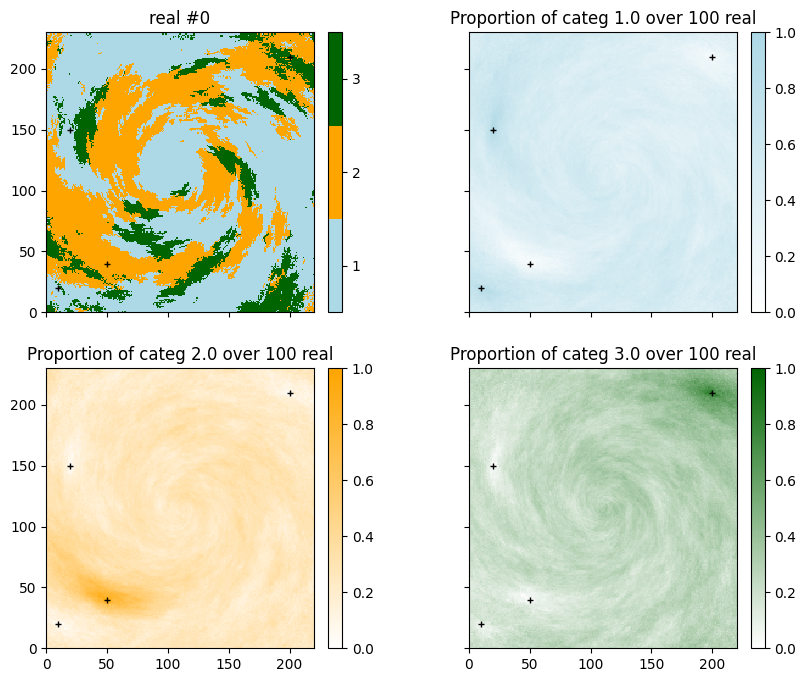

In [31]:
# Plot
plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    gn.imgplot.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Proportion of categ {} over {} real'.format(category_values[i], nreal))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()

#### Estimation: estimate probabilities
*Note:* unique search neighorhood can not be used with a non-stationary covariance model.

Extract random points from the first realization to set conditioning data.

In [32]:
im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=1, val=simul.val[0])
ps = gn.img.extractRandomPointFromImage(im, 200, seed=444)
new_x = ps.val[0:2].T # location of conditioning data
new_v = ps.val[3]     # value at conditioning data

In [33]:
# Increase searchRadiusRelative to avoid "discontinuities"
geosclassic_output = gn.geosclassicinterface.estimateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=new_x, v=new_v, method='simple_kriging',
    searchRadiusRelative=2.0,
    nthreads=8)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete


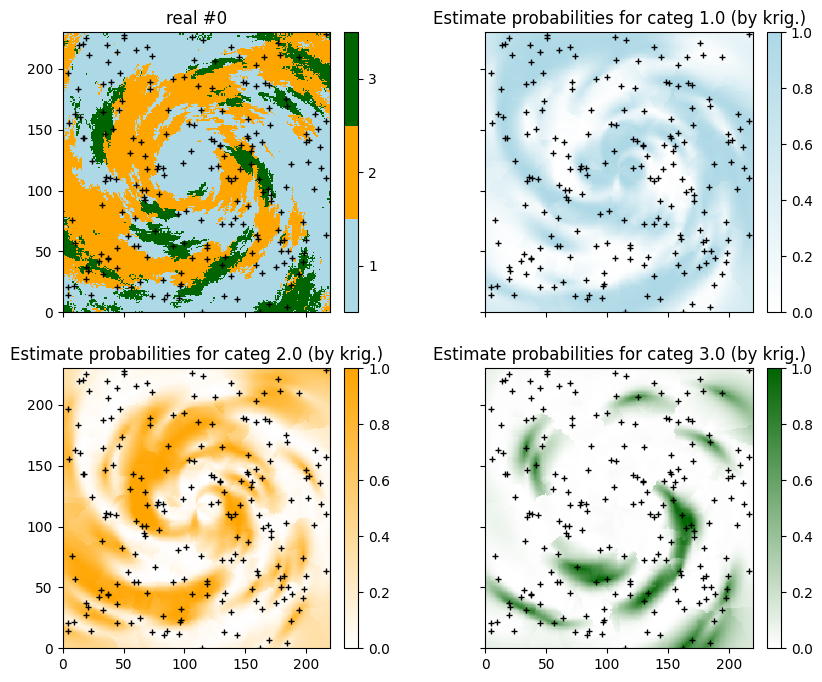

In [34]:
# Plot
plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(simul, iv=0, categ=True, categCol=categCol, title='real #0')
plt.plot(new_x[:,0],new_x[:,1], '+', c='black', markersize=5) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    gn.imgplot.drawImage2D(estim, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Estimate probabilities for categ {} (by krig.)'.format(category_values[i]))
    plt.plot(new_x[:,0],new_x[:,1], '+', c='black', markersize=5) # add conditioning point locations

plt.show()